In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [2]:
path='/kaggle/input/jee-2013-2020-dataset/jee_mains_2013_to_2025_top_30_ranks.csv'
df=pd.read_csv(path)
df

,Year,Exam_Date,Name,Category,Sex,State,Maths_Marks,Physics_Marks,Chemistry_Marks,Total_Marks,Rank,Percentile
0,2013,2013-04-21,Tristan Bhandari,General,F,Uttar Pradesh,75,83,48,206,78,51.572327
1,2013,2013-04-18,Rehaan Rajagopalan,General,M,Rajasthan,71,85,62,218,66,59.119497
2,2013,2013-04-19,Yatin Natarajan,General,F,Rajasthan,67,94,73,234,50,69.182390
3,2013,2013-04-21,Peter Bhalla,Reserved,F,Uttar Pradesh,52,71,66,189,85,39.130435
4,2013,2013-04-17,Jairaj Mannan,General,M,Gujarat,40,65,65,170,114,28.930818
...,...,...,...,...,...,...,...,...,...,...,...,...
25995,2025,2025-04-17,Ronith Chakraborty,General,M,West Bengal,70,89,41,200,81,49.044586
25996,2025,2025-04-17,Mitali Nayak,General,M,Uttar Pradesh,74,51,58,183,98,38.216561
25997,2025,2025-04-18,Ijaya Sabharwal,Reserved,F,Madhya Pradesh,41,87,32,160,116,21.232877
25998,2025,2025-04-16,Aadhya Sankar,Reserved,M,West Bengal,65,99,61,225,51,65.753425


In [3]:
selected_rows = df[df['Year'] == 2013].copy()
selected_columns_and_rows = selected_rows.iloc[:, 6:9]
percentile=selected_rows.iloc[:,11]
selected_columns_and_rows.insert(loc=3,column='percentage',value=percentile)
selected_columns_and_rows['percentage']=np.where(selected_columns_and_rows['percentage']>50.5,1,0)
print(selected_columns_and_rows)

      Maths_Marks  Physics_Marks  Chemistry_Marks  percentage
0              75             83               48           1
1              71             85               62           1
2              67             94               73           1
3              52             71               66           0
4              40             65               65           0
...           ...            ...              ...         ...
1995           94             71               57           1
1996           73             98               69           1
1997           48             74               44           0
1998           99             94               35           1
1999          100             82               56           1

[2000 rows x 4 columns]


In [4]:
class Module(nn.Module):
    def __init__(self,in_feature=3,H1=20,H2=15,out_feature=2):
        super().__init__()
        self.fc1=nn.Linear(in_feature,H1)
        self.fc2=nn.Linear(H1,H2)
        self.out=nn.Linear(H2,out_feature)

    def forward(self,x):
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.out(x)

        return x

In [5]:
torch.manual_seed(64)
model=Module()

In [6]:
X=selected_columns_and_rows.drop(columns=['percentage']).values
Y=selected_columns_and_rows['percentage'].values

In [7]:
Y

array([1, 1, 1, ..., 0, 1, 1])

In [8]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=64)

In [9]:
x_train=torch.FloatTensor(x_train)
x_test=torch.FloatTensor(x_test)

In [10]:
y_train=torch.LongTensor(y_train)
y_test=torch.LongTensor(y_test)

In [11]:
x_train.shape

torch.Size([1600, 3])

In [12]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)

In [13]:
model.parameters

<bound method Module.parameters of Module(
  (fc1): Linear(in_features=3, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=15, bias=True)
  (out): Linear(in_features=15, out_features=2, bias=True)
)>

In [14]:
epochs=100
losses=[]
for i in range(epochs):

    y_pred=model.forward(x_train)


    loss=criterion(y_pred,y_train)

    losses.append(loss.detach().numpy())

    if i%10==0:
        print(f'Epoch:{i} and loss: {loss}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch:0 and loss: 2.8073337078094482
Epoch:10 and loss: 0.7208411693572998
Epoch:20 and loss: 0.7064096927642822
Epoch:30 and loss: 0.6719658374786377
Epoch:40 and loss: 0.6576196551322937
Epoch:50 and loss: 0.6462653875350952
Epoch:60 and loss: 0.6331533193588257
Epoch:70 and loss: 0.6199908256530762
Epoch:80 and loss: 0.6059129238128662
Epoch:90 and loss: 0.5917690396308899


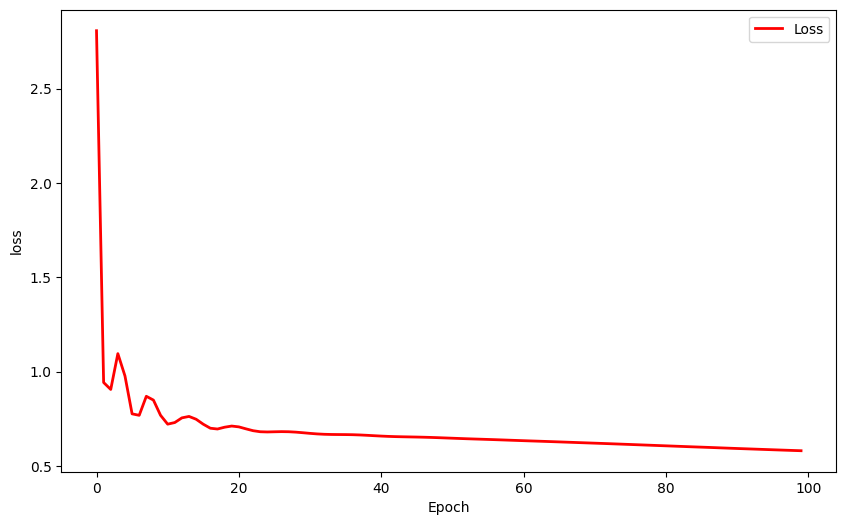

In [15]:
plt.figure(figsize=(10,6))
plt.plot(range(epochs),losses,'r',label='Loss',linewidth=2)
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()

In [16]:
with torch.no_grad():
    y_eval=model.forward(x_test)
    loss=criterion(y_eval,y_test)

In [17]:
loss

tensor(0.5760)

In [18]:
results = []
correct=0
with torch.no_grad():
    for i, data in enumerate(x_test):
        y_val = model.forward(data)
        
        is_correct = 1 if y_val.argmax().item() == y_test[i] else 0
        results.append(is_correct)
        
        if is_correct:
            correct += 1

print(f'We got {correct} correct')


We got 264 correct


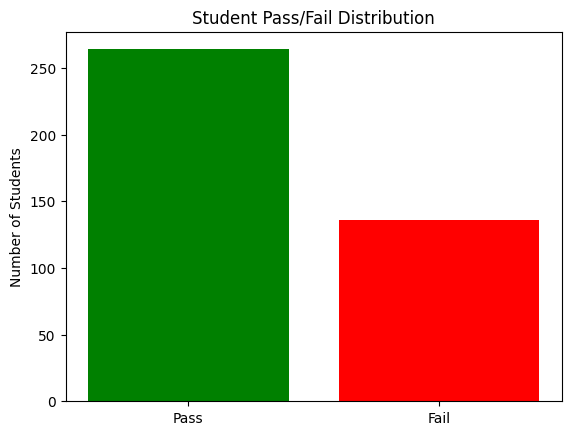

In [19]:
import matplotlib.pyplot as plt

passed = sum(results)
failed = len(results) - passed

plt.bar(['Pass', 'Fail'], [passed, failed], color=['green', 'red'])
plt.title('Student Pass/Fail Distribution')
plt.ylabel('Number of Students')
plt.show()


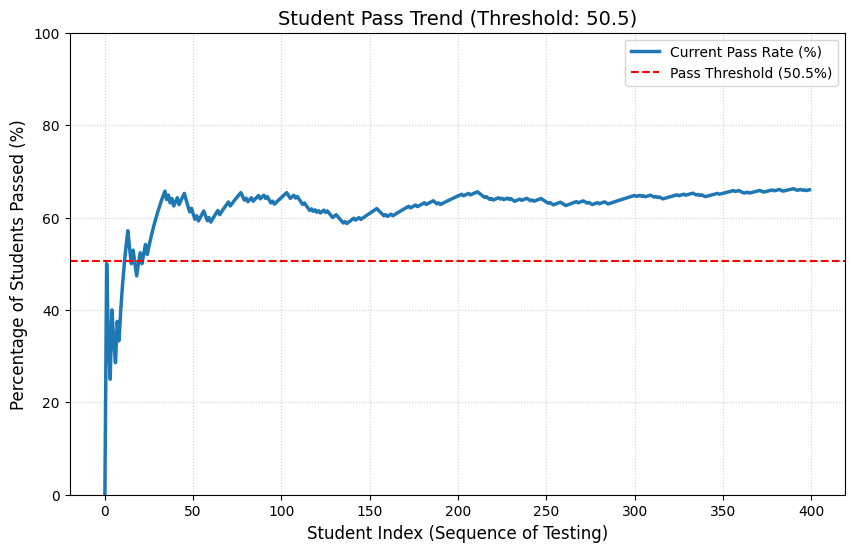

In [20]:
import numpy as np
import matplotlib.pyplot as plt
cumulative_pass_rate = np.cumsum(results) / (np.arange(len(results)) + 1) * 100

plt.figure(figsize=(10, 6))

plt.plot(cumulative_pass_rate, color='#1f77b4', linewidth=2.5, label='Current Pass Rate (%)')

plt.axhline(y=50.5, color='r', linestyle='--', label='Pass Threshold (50.5%)') 

plt.title('Student Pass Trend (Threshold: 50.5)', fontsize=14)
plt.xlabel('Student Index (Sequence of Testing)', fontsize=12)
plt.ylabel('Percentage of Students Passed (%)', fontsize=12)
plt.ylim(0, 100)
plt.legend(loc='upper right')
plt.grid(True, linestyle=':', alpha=0.6)

plt.show()
